# Regulome Explorer Wilcoxon rank sum test associations of mutation and gene expression

Check out more notebooks at our ['Regulome Explorer Repository'](https://github.com/isb-cgc/Community-Notebooks/tree/master/RegulomeExplorer)!

```
Title:   Regulome Explorer Wilcoxon rank sum test associations of mutation and gene expression
Author:  Boris Aguilar
Created: 02-10-2021
Purpose: Demonstrate how to use BigQuery and the Wilcoxon rank sum test, implemented as a BigQuery function, to find significant associations between gene expression and somatic mutation data available in the Pancancer Atlas dataset.
URL:     https://github.com/isb-cgc/Community-Notebooks/blob/master/RegulomeExplorer/BigQuery-WilcoxonRankSumTest.ipynb
```

### Libraries 

In [1]:
from google.cloud import bigquery
from google.colab import auth
import pandas_gbq
import seaborn as sns

### Authentication
The first step is to authorize access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html) and alternative authentication methods can be found [here](https://googleapis.github.io/google-cloud-python/latest/core/auth.html).

In [2]:
auth.authenticate_user()
my_project_id = "" # write your project id here
bqclient = bigquery.Client( my_project_id )

### Parameteres

In [3]:
cancer_type = 'GBM'
gene_expre = 'CLGN'
gene_mutation = 'TP53'

### Data from BigQuery tables
The first step is to select all participants in the selected study with a least one mutation.

In [4]:
barcode_set = """barcodes AS (
   SELECT DISTINCT Tumor_SampleBarcode AS SampleBarcode   
   FROM `pancancer-atlas.Filtered.MC3_MAF_V5_one_per_tumor_sample`
   WHERE Study = '{0}'       
)
""".format(cancer_type)

**Gene expression data from the BigQuery:** The following query string retrieves the gene expression data of the user specified gene ('gene_expre') from the 'Filtered.EBpp_AdjustPANCAN_IlluminaHiSeq_RNASeqV2_genExp_filtered' table available in pancancer-atlas dataset. The gene expression of a participant is computed as the average gene expression of the tumor samples of the participant. Moreover, we are considering only samples with a least somatic mutation.

In [5]:
query_table1 = """table1 AS (
   SELECT 
         Symbol AS symbol, AVG( LOG10(normalized_count+1) ) AS data, ParticipantBarcode
   FROM  `pancancer-atlas.Filtered.EBpp_AdjustPANCAN_IlluminaHiSeq_RNASeqV2_genExp_filtered` 
   WHERE Study = '{0}' AND Symbol ='{1}' AND normalized_count IS NOT NULL
         AND SampleBarcode  IN (SELECT * FROM barcodes)
   GROUP BY ParticipantBarcode, symbol
)
""".format(cancer_type, gene_expre)

**Somatic mutation data from the BigQuery:** The following string query will retrieve a table with patients with at least one Somatic mutation in the user defined gene ('mutation_name'). This information is extracted from the 'pancancer-atlas.Filtered.MC3_MAF_V5_one_per_tumor_sample' table, available in pancancer-atlas dataset. Notice that we only use samples in which FILTER = 'PASS'.

In [6]:
query_table2 = """table2 AS (
   SELECT
      ParticipantBarcode AS ParticipantBarcode
   FROM `pancancer-atlas.Filtered.MC3_MAF_V5_one_per_tumor_sample`
   WHERE Study = '{0}' AND Hugo_Symbol = '{1}'
         AND FILTER = 'PASS'  
   GROUP BY ParticipantBarcode
)
""".format(cancer_type,gene_mutation)

At this point we can take a look at the combined data (Gene expression and Somatic mutation) by using a simple LEFT JOIN command. Participants with and without somatic mutations are labeled as 'YES' and 'NO' respectively.

In [7]:
sql_data = 'WITH\n'+ barcode_set+','+ query_table1+','+query_table2  

sql = (sql_data + 
"""
SELECT 
    n1.data as gexp,  
    IF( n2.ParticipantBarcode is null, 'NO', 'YES') as mutation,  
    n1.ParticipantBarcode
FROM
    table1 n1  
LEFT JOIN  table2   n2 
ON  n1.ParticipantBarcode = n2.ParticipantBarcode
""")

df_data = pandas_gbq.read_gbq(sql,project_id=my_project_id )
df_data[1:10]

Downloading: 100%|██████████| 154/154 [00:00<00:00, 1252.17rows/s]


,gexp,mutation,ParticipantBarcode
1,2.362403,NO,TCGA-06-0168
2,1.675059,NO,TCGA-28-5213
3,2.017246,NO,TCGA-28-2510
4,1.138404,NO,TCGA-14-1823
5,2.126560,YES,TCGA-06-0221
6,1.354471,NO,TCGA-32-5222
7,2.350893,YES,TCGA-02-2485
8,1.023170,NO,TCGA-28-2513
9,0.573591,NO,TCGA-06-5414


### Visualization 
To visualize the gene expression data in both groups with or without somatic mutation, we can use a 'violinplot' plot:

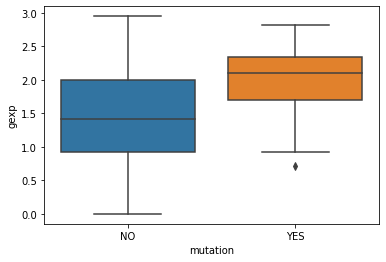

In [8]:
sns.boxplot(x="mutation", y="gexp", data=df_data)

### Statistical test using BigQuery
The [Mann Whitney U](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) or Wilcoxon ranked summ test is a popular nonparametric statistical test used to test whether two samples are likely to derive from the same population. The test is implemented as BigQuery function and it will be used here to test whether the distribution of gene expression of mutated and non mutated samples have same distribution (Null hypothesis). 

The following query uses the Mann Whitney U test to compute the p-value of the null hypothesis: 

In [9]:
sql = (sql_data + 
"""
SELECT `isb-cgc-bq.functions.mannwhitneyu_current`(arr_mut, arr_nomut, 'two-sided') AS test
FROM ( 
    SELECT     
        ARRAY_AGG(IF( n2.ParticipantBarcode IS NULL, NULL,n1.data ) IGNORE NULLS ) as arr_mut,
        ARRAY_AGG(IF( n2.ParticipantBarcode IS NULL, n1.data, NULL) IGNORE NULLS ) as arr_nomut
    FROM
        table1 n1  
    LEFT JOIN  table2   n2 
    ON  n1.ParticipantBarcode = n2.ParticipantBarcode
)
""")
df_stat = pandas_gbq.read_gbq(sql,project_id=my_project_id )
df_stat

Downloading: 100%|██████████| 1/1 [00:00<00:00,  9.53rows/s]


,test
0,"{'U': 1368.0, 'p': 9.407515808579348e-07}"


Where U and p are the U statistics and the p-value of the Mann Whitney U test. More details can be found [here](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test). 
